In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import shapely
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
from splot import esda as esdaplot

import classes.entropycalculator as ec

c:\Users\joepl\anaconda3\envs\scriptie_38\lib\site-packages\spaghetti\network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [3]:
# neighbourhood plot
# db = gpd.read_parquet('results/filter2/buurten/Amsterdam_buurten_2.parquet')
db = gpd.read_parquet('results/filter2/wijken/Eindhoven_wijken_2.parquet')
db.reset_index(drop=True, inplace=True)
# amenities = gpd.read_parquet('data/gm_amenities/amenities_Amsterdam.parquet')

db = db[['wijkcode', 'geometry', 'L0_altieri', 'L0_leibovici', 'L1_altieri', 'L1_leibovici', 'L0_shannon', 'L1_shannon']]	
db.dropna(subset=['L0_altieri'], inplace=True)
db

,wijkcode,geometry,L0_altieri,L0_leibovici,L1_altieri,L1_leibovici,L0_shannon,L1_shannon
0,WK077211,"POLYGON ((5.50103 51.44646, 5.50212 51.44519, ...",5.445673,3.850339,8.133799,6.589117,2.285329,3.742271
1,WK077221,"POLYGON ((5.50324 51.43258, 5.50297 51.43181, ...",5.549777,4.631456,7.992950,7.047221,2.723821,3.970824
2,WK077222,"POLYGON ((5.48876 51.42367, 5.49029 51.42365, ...",4.677123,4.014950,6.429684,5.704684,2.374453,3.260209
3,WK077223,"POLYGON ((5.53209 51.43218, 5.53204 51.43199, ...",5.518485,4.633153,6.886671,6.315038,2.722610,3.585666
4,WK077231,"POLYGON ((5.50439 51.43578, 5.50405 51.43491, ...",5.693460,4.852473,7.656861,6.802786,2.849241,3.856647
5,WK077232,"POLYGON ((5.53317 51.43292, 5.53475 51.43168, ...",5.806719,4.899701,7.258352,6.133444,2.870667,3.503661
6,WK077233,"POLYGON ((5.51495 51.46528, 5.51496 51.46525, ...",4.912122,4.232321,6.122662,5.284836,2.502984,3.043221
7,WK077241,"POLYGON ((5.48442 51.45288, 5.48418 51.45221, ...",4.851681,3.667973,7.229634,6.113077,2.192225,3.498055
8,WK077242,"POLYGON ((5.45366 51.46269, 5.45432 51.46204, ...",5.541466,4.763273,7.338253,6.779838,2.796744,3.834115
9,WK077243,"POLYGON ((5.51182 51.46729, 5.51223 51.46699, ...",5.418580,4.553693,6.964277,6.029998,2.669207,3.422117


C:\Users\joepl\AppData\Local\Temp\ipykernel_26660\2773312906.py:39: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


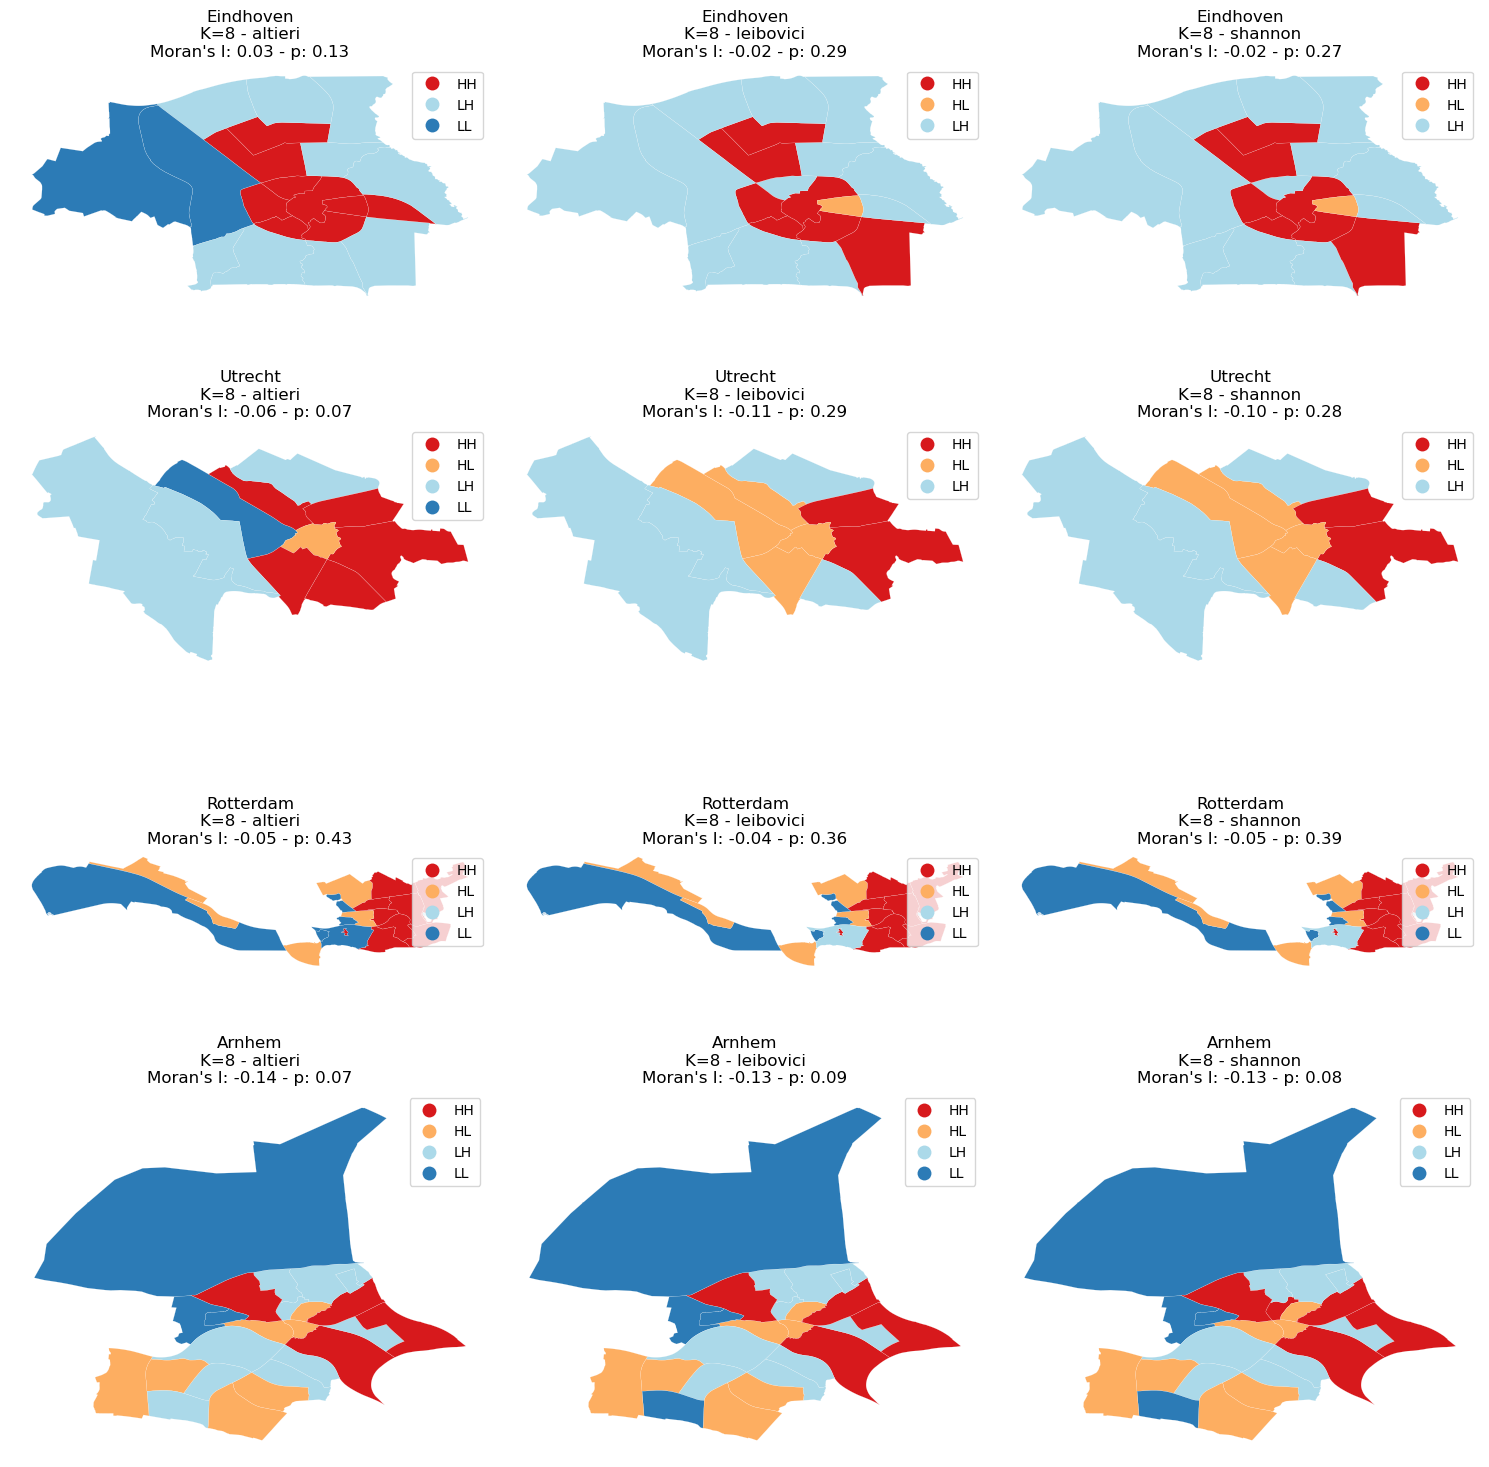

In [4]:
metrics = ['altieri', 'leibovici', 'shannon'] 

# Set up figure and axes
f, axs = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
# Make the axes accessible with single indexing
# axs = axs.flatten()
for i, metric in enumerate(metrics):
    for j, mun in enumerate(['Eindhoven', 'Utrecht', 'Rotterdam', 'Arnhem']):
        
        db = gpd.read_parquet(f'results/filter2/wijken/{mun}_wijken_2.parquet')
        # db = gpd.read_parquet('results/filter2/wijken/Eindhoven_wijken_2.parquet')
        db.reset_index(drop=True, inplace=True)
        # amenities = gpd.read_parquet('data/gm_amenities/amenities_Amsterdam.parquet')

        db = db[['wijkcode', 'geometry', 'L0_altieri', 'L0_leibovici', 'L1_altieri', 'L1_leibovici', 'L0_shannon', 'L1_shannon']]	
        db.dropna(subset=['L0_altieri', 'L1_altieri'], inplace=True)
        
        k_n = 8
        ax = axs[j, i]
        # Create the weights
        w = weights.KNN.from_dataframe(db, k=k_n)
        # w = weights.contiguity.Queen.from_dataframe(db, use_index=False)
        w.transform = "R"

        db[f"w_{metric}"] = weights.lag_spatial(w, db[f'L1_{metric}'])
        db[f"{metric}_std"] = db[f"L1_{metric}"] - db[f"L1_{metric}"].mean()
        db[f"w_{metric}_std"] = weights.lag_spatial(w, db[f'{metric}_std'])
        
        lisa = esda.Moran_Local(db[f"L1_{metric}"], w)
        moran = esda.moran.Moran(db[f"L1_{metric}"], w)
        
        esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)
        ax.set_axis_off()
        ax.set_title(f"{mun}\nK={k_n} - {metric}\nMoran's I: {moran.I:.2f} - p: {moran.p_sim:.2f}")
        

        
f.tight_layout()
f.show()
    

In [22]:
import plotly.express as px

codedict = {'wijken': 'wijkcode', 'buurten': 'buurtcode'}

scale = 'wijken'
col = 'L0_c_Entertainment, arts and culture'
gm = 'Amsterdam'
gdf = gpd.read_parquet(f'results/filter2/{scale}/{gm}_{scale}_2.parquet')

# gdf.loc[:, 'geb_NL'] = gdf['P_GEBNL_EU'] + gdf['P_GEBNL_NE'] + gdf['P_GEBNL_NL']


w = weights.contiguity.Queen.from_dataframe(gdf, use_index=False)
w.transform = "R"

lisa = esda.Moran_Local(gdf[f"{col}"], w)

gdf.loc[:, 'lisa'] = lisa.q

fig = px.choropleth(gdf, geojson=gdf.geometry, locations=gdf.index, color='lisa')
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

c:\Users\joepl\anaconda3\envs\scriptie_38\lib\site-packages\libpysal\weights\weights.py:224: UserWarning:

The weights matrix is not fully connected: 
 There are 2 disconnected components.



(<Figure size 640x480 with 1 Axes>, <Axes: >)

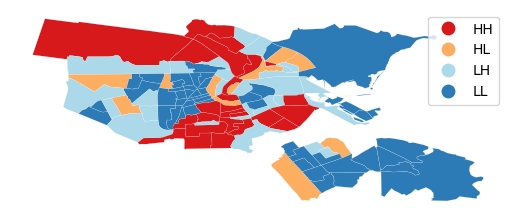

In [24]:
esdaplot.lisa_cluster(lisa, gdf, p=1)